In [1]:
#mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#path of example directory
path = "/content/gdrive/MyDrive/openCV assignment/"

In [3]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
# from PIL import Image
import matplotlib.pyplot as plt

In [4]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


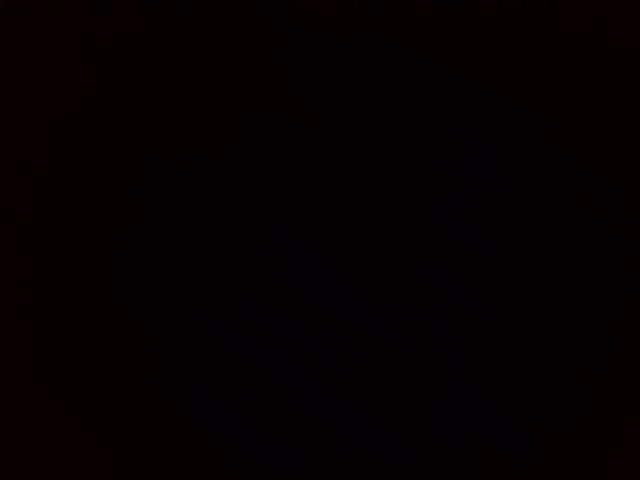

In [5]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [6]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [7]:
def displayImage(image):
    if len(image.shape)==3:
        color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(color_coverted)
        plt.show()
        
    else:
        plt.imshow(image, cmap="gray")
        plt.show()

In [9]:
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

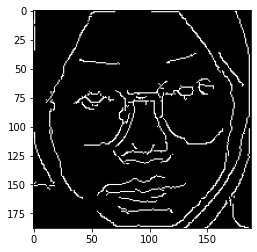

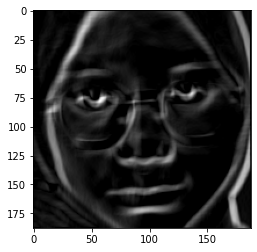

In [10]:
# initialze bounding box to empty
bbox = ''
count = 0 

# create transparent overlay for bounding box
bbox_array = np.zeros([400,630,4], dtype=np.uint8)

img = cv2.imread(path+"photo1.jpg")

# grayscale image for face detection
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

imgBlur = cv2.GaussianBlur(gray,(7,7),5)

# get face region coordinates
faces = face_cascade.detectMultiScale(gray)

# get face bounding box for overlay
for (x,y,w,h) in faces:
  bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

  # canny
  imgCanny = cv2.Canny(imgBlur[y:y+h, x:x+w],20,100)

  # sobel
  sobelx = cv2.Sobel(imgBlur[y:y+h, x:x+w], cv2.CV_8U,1,0,ksize=3)
  sobely = cv2.Sobel(imgBlur[y:y+h, x:x+w], cv2.CV_8U,0,1,ksize=3)
  imgSobel = sobelx + sobely

bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
# convert overlay of bbox into bytes
bbox_bytes = bbox_to_bytes(bbox_array)
# update bbox so next frame gets new overlay
bbox = bbox_bytes

displayImage(imgCanny)
displayImage(imgSobel)

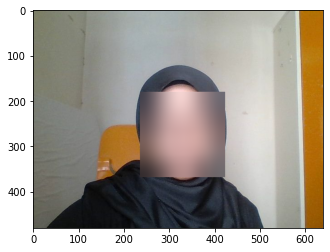

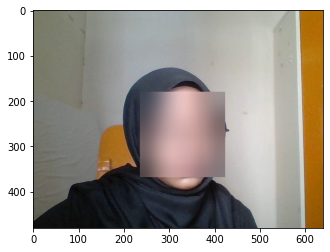

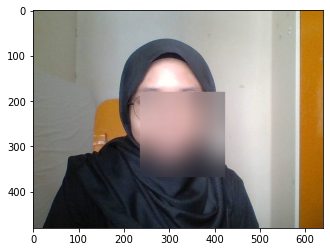

In [11]:
# initialze bounding box to empty
bbox = ''
count = 0 

# convert JS response to OpenCV Image
img1 = cv2.imread(path+"photo1.jpg")
img2 = cv2.imread(path+"photo2.jpg")
img3 = cv2.imread(path+"photo3.jpg")

# create transparent overlay for bounding box
bbox_array = np.zeros([400,630,4], dtype=np.uint8)

# grayscale image for face detection
gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
# gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
# gray3 = cv2.cvtColor(img3, cv2.COLOR_RGB2GRAY)

img_rgb1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img_rgb3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# get face region coordinates
faces = face_cascade.detectMultiScale(gray)

imgBlur1 = img_rgb1.copy()
imgBlur2 = img_rgb2.copy()
imgBlur3 = img_rgb3.copy()

# get face bounding box for overlay
for (x,y,w,h) in faces:
  bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

  imgBlur1[y:y+h, x:x+w] = cv2.GaussianBlur(imgBlur1[y:y+h, x:x+w] ,(99,99), 30)
  imgBlur2[y:y+h, x:x+w] = cv2.GaussianBlur(imgBlur2[y:y+h, x:x+w] ,(99,99), 30)
  imgBlur3[y:y+h, x:x+w] = cv2.GaussianBlur(imgBlur3[y:y+h, x:x+w] ,(99,99), 30)

bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
# convert overlay of bbox into bytes
bbox_bytes = bbox_to_bytes(bbox_array)
# update bbox so next frame gets new overlay
bbox = bbox_bytes


#plt.imshow(img_rgb)
#plt.imshow(bbox_array)
#plt.show()

plt.imshow(imgBlur1)
#plt.imshow(bbox_array)
plt.show()

#plt.imshow(img_rgb2)
#plt.imshow(bbox_array)
#plt.show()

plt.imshow(imgBlur2)
#plt.imshow(bbox_array)
plt.show()

#plt.imshow(img_rgb3)
#plt.imshow(bbox_array)
#plt.show()

plt.imshow(imgBlur3)
#plt.imshow(bbox_array)
plt.show()

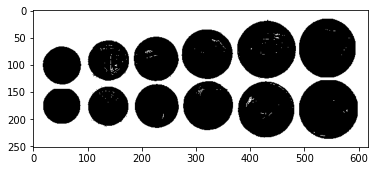

In [12]:
img_coins = cv2.imread(path+"coins.png")
gray_coins = cv2.cvtColor(img_coins, cv2.COLOR_RGB2GRAY)

(thresh, blackAndWhiteImage) = cv2.threshold(gray_coins, 240, 255, cv2.THRESH_BINARY)

#plt.imshow(gray, cmap="gray")
displayImage(blackAndWhiteImage)

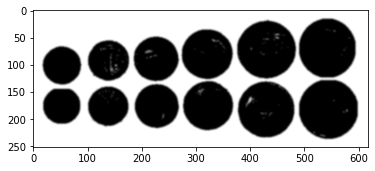

In [13]:
img_blur = cv2.GaussianBlur(blackAndWhiteImage,(7,7),0)
plt.imshow(img_blur, cmap="gray")

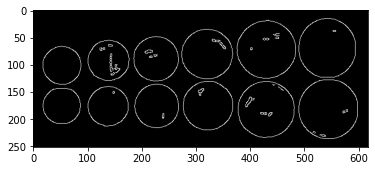

In [14]:
imgCanny = cv2.Canny(img_blur, 30, 150, 3)
plt.imshow(imgCanny, cmap="gray")

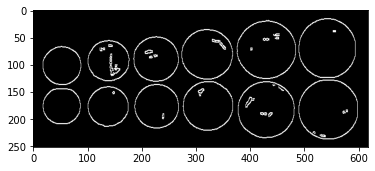

In [15]:
imgDilate = cv2.dilate(imgCanny, (1,1), iterations = 1)
plt.imshow(imgDilate, cmap="gray")

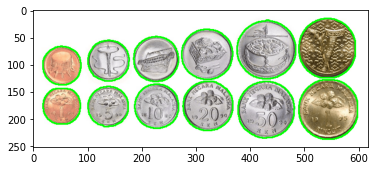

In [16]:
(cnt,hierarchy) = cv2.findContours(imgDilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

img_rgb = cv2.cvtColor(img_coins, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, cnt, -1, (0,255,0), 2)

plt.imshow(img_rgb)

In [17]:
print('Coins in the image: ', len(cnt))

Coins in the image:  12
